In [ ]:
pip install tqdm

In [ ]:
pip install seaborn


In [ ]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

In [ ]:
TEST_SIZE = 0.5
RANDOM_STATE = 2020
BATCH_SIZE = 64
NO_EPOCHS = 2
NUM_CLASSES = 2
IMG_SIZE = 75


In [ ]:
LR = 1e-3

In [ ]:
def label_img(img):
    word_label = img.split('.')[-3]
    # DIY One hot encoder
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog': return [0, 1]

In [ ]:
def create_train_data():
    # Creating an empty list where we should store the training data
    # after a little preprocessing of the data
    training_data = []
 
    # tqdm is only used for interactive loading
    # loading the training data
    for img in tqdm(os.listdir('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/train/')):
 
        # labeling the images
        label = label_img(img)
 
        path = os.path.join('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/train/', img)
 
        # loading the image from the path and then converting them into
        # grayscale for easier covnet prob
        img = cv2.imread(path ,-1)
 
        # resizing the image for processing them in the covnet
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
 
        # final step-forming the training data list with numpy array of the images
        training_data.append([np.array(img), np.array(label)])
 
    # shuffling of the training data to preserve the random state of our data
    shuffle(training_data)
 
    # saving our trained data for further uses if required
    np.save('train_data_224.npy', training_data)
    return training_data

In [ ]:
train_data = create_train_data()
test_data = process_test_data()

In [ ]:
train_data = np.load('/content/drive/MyDrive/train_data.npy',allow_pickle=True)
test_data = np.load('/content/drive/MyDrive/test_data.npy',allow_pickle=True)


In [ ]:
X = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train_data])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)


In [ ]:
pip install tflearn

     |████████████████████████████████| 107 kB 31.1 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=1e8249de5292be8a01bb09a0a859ba30dba01aa3e5c7c50214eb495b6a90d70b
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [ ]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
 
import tensorflow as tf
tf.compat.v1.reset_default_graph()
model = Sequential()
convnet = input_data(shape =[None,IMG_SIZE, IMG_SIZE, 3], name ='input')
 
convnet = conv_2d(convnet, 32, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)
 
convnet = conv_2d(convnet, 64, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)
 
convnet = conv_2d(convnet, 128, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)
 
convnet = conv_2d(convnet, 64, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)
 
convnet = conv_2d(convnet, 32, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)
 
convnet = fully_connected(convnet, 1024, activation ='relu')
convnet = dropout(convnet, 0.8)
 
convnet = fully_connected(convnet, 2, activation ='softmax')
convnet = regression(convnet, optimizer ='adam', learning_rate = LR,
      loss ='categorical_crossentropy', name ='targets')
 
model = tflearn.DNN(convnet, tensorboard_dir ='log')
 

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
history = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  n_epoch=10,
                  validation_set=(X_val, y_val),
                  show_metric = True)

Training Step: 1959  | total loss: 0.17229 | time: 2.468s
| Adam | epoch: 010 | loss: 0.17229 - acc: 0.9269 -- iter: 12480/12500
Training Step: 1960  | total loss: 0.18489 | time: 4.171s
| Adam | epoch: 010 | loss: 0.18489 - acc: 0.9249 | val_loss: 0.69664 - val_acc: 0.7879 -- iter: 12500/12500
--


In [ ]:
score = model.evaluate(X_val, y_val )

print('Validation accuracy:', score)

Validation accuracy: [0.7879199998092651]


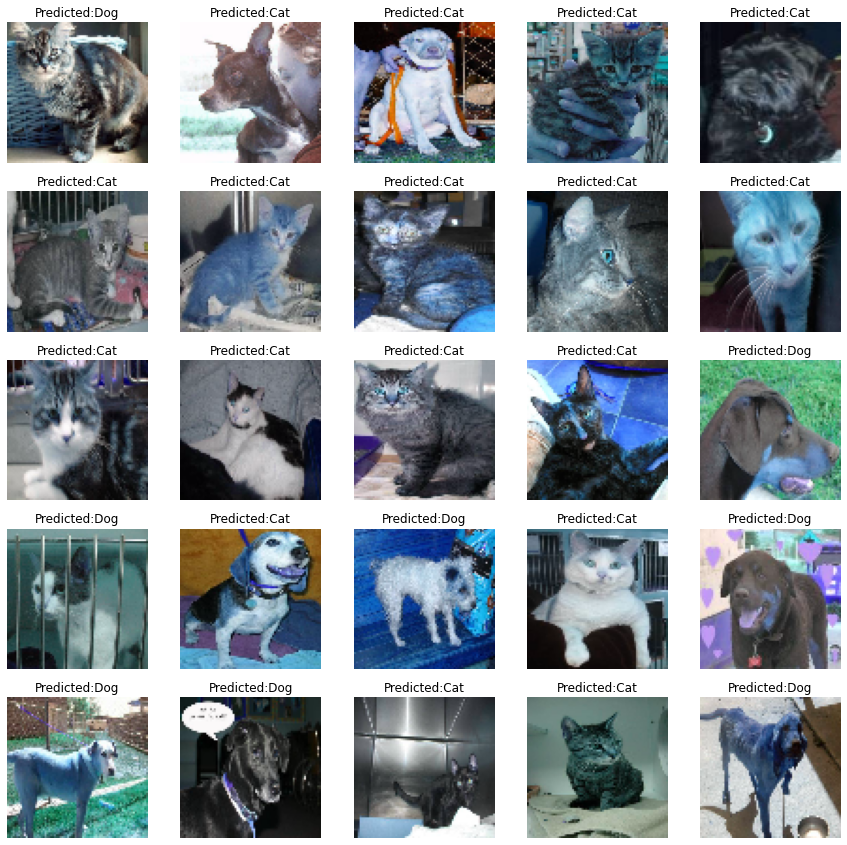

In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test_data[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

In [ ]:
pred_list = []
img_list = []
for img in tqdm(test_data):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,3)
    predicted = (model.predict([data])[0])
    img_list.append(img_idx)
    pred_list.append(round(predicted[1]))

100%|██████████| 12500/12500 [00:27<00:00, 446.77it/s]


In [ ]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission_CNN_75.csv", index=False)